<a href="https://colab.research.google.com/github/Stegen54/Object_Detection/blob/main/AI_Powered_Home_Security_System_%7C_Object_Detection_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The datasets used in this project can be found from https://research.google.com/youtube-bb/download.html. Ensure to upload the training and validation datasets to Google Drive

# Object Detection using Convolutional Neural Networks

## Step 1

Install Required Libraries

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

import numpy as np
import tensorflow as tf
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
from pathlib import Path
import itertools

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.models import Model

## Step 2: Load and Preprocess the dataset

a. Load the datasets

In [ ]:
# Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the validation dataset

import gzip
import csv

val_csv = '/content/drive/MyDrive/yt_bb_detection_validation.csv.gz'
try:
    with gzip.open(val_csv, mode='rt') as f:
        reader = csv.reader(f)
        # for row in reader:
        #     print(row)
except EOFError as e:
    print("EOFError: ", e)
except Exception as e:
    print("An error occured: ", e)

Adding the labels to the dataset cause it was missing when we loaded the dataset.


In [ ]:
fstr = """youtube_id
    timestamp_ms
    class_id
    class_name
    object_id
    object_presence
    xmin
    xmax
    ymin
    ymax
"""
col_names = fstr.split()
col_names

['youtube_id',
 'timestamp_ms',
 'class_id',
 'class_name',
 'object_id',
 'object_presence',
 'xmin',
 'xmax',
 'ymin',
 'ymax']

In [ ]:
# Load the training dataset

train_csv = '/content/drive/MyDrive/yt_bb_detection_train.csv.gz'

try:
    with gzip.open(train_csv, 'rt') as f:
        df = pd.read_csv(f, names=col_names)
        df = df.sample(n=1000, random_state=42)
        print(df.head())
except EOFError as e:
    print("EOFError: ", e)
except Exception as e:
    print("An error occurred: ", e)

df.info()
df['url'] = df['youtube_id'].apply(lambda x: f'https://www.youtube.com/watch?v={x}')
df.head(3)


          youtube_id  timestamp_ms  class_id  class_name  object_id  \
1763057  KeY_Y6IZJRQ        511000         0      person          0   
1130511  GruxXrzWzjk        250000        13    airplane          0   
187741   BHDY6MkT7nA         54000        14  skateboard          1   
5331268  806VikN2gW0         83000         2     bicycle          2   
23909    AJcg_8qRnN8         19000        12       knife          0   

        object_presence   xmin   xmax      ymin      ymax  
1763057          absent -1.000 -1.000 -1.000000 -1.000000  
1130511         present  0.173  0.976  0.323333  0.606667  
187741          present  0.462  0.625  0.540000  0.611667  
5331268          absent -1.000 -1.000 -1.000000 -1.000000  
23909           present  0.200  1.000  0.000000  1.000000  
<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 1763057 to 3910348
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   youtu

,youtube_id,timestamp_ms,class_id,class_name,object_id,object_presence,xmin,xmax,ymin,ymax,url
1763057,KeY_Y6IZJRQ,511000,0,person,0,absent,-1.000,-1.000,-1.000000,-1.000000,https://www.youtube.com/watch?v=KeY_Y6IZJRQ
1130511,GruxXrzWzjk,250000,13,airplane,0,present,0.173,0.976,0.323333,0.606667,https://www.youtube.com/watch?v=GruxXrzWzjk
187741,BHDY6MkT7nA,54000,14,skateboard,1,present,0.462,0.625,0.540000,0.611667,https://www.youtube.com/watch?v=BHDY6MkT7nA


b. Preprocess the CSV data

In [ ]:
def preprocess_csv(df):
    df['youtube_id'] = df['youtube_id'].astype(str)
    df['timestamp_ms'] = df['timestamp_ms'].astype(int)
    df['xmin'] = df['xmin'].astype(float)
    df['xmax'] = df['xmax'].astype(float)
    df['ymin'] = df['ymin'].astype(float)
    df['ymax'] = df['ymax'].astype(float)
    return df

train_data = preprocess_csv(train_csv)
val_data = preprocess_csv(val_csv)

TypeError: string indices must be integers

c. Extract frame from videos

In [ ]:
!pip install pytube

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 927.9 kB/s eta 0:00:00


In [ ]:
from pytube import YouTube
import pandas as pd

# Path to save the videos
SAVE_PATH = "/content/drive/MyDrive/Detection_Videos"  # Update to your desired path


# Links of the videos to be downloaded
links = df['url'].tolist()[:1000]

def download_video(link, save_path):
    try:
        # Object creation using YouTube
        yt = YouTube(link)
        # Get all streams and filter for mp4 files
        mp4_streams = yt.streams.filter(file_extension='mp4')
        # Get the video with the highest resolution
        d_video = mp4_streams.get_highest_resolution()
        # Download the video
        d_video.download(output_path=save_path)
        print(f'Video downloaded successfully: {link}')
        return True
    except Exception as e:
        print(f"Error downloading {link}: {e}")
        return False

# Main function to download videos
def main():
    available_links = []
    for link in links:
        if download_video(link, SAVE_PATH):
            available_links.append(link)

    # Save the available links to a new CSV file
    available_df = pd.DataFrame(available_links, columns=['url'])
    available_df.to_csv('available_videos.csv', index=False)
    print('Task Completed!')

# Execute the main function
if __name__ == "__main__":
    main()


Video downloaded successfully: https://www.youtube.com/watch?v=KeY_Y6IZJRQ
Error downloading https://www.youtube.com/watch?v=GruxXrzWzjk: GruxXrzWzjk is unavailable
Error downloading https://www.youtube.com/watch?v=BHDY6MkT7nA: BHDY6MkT7nA is a private video
Video downloaded successfully: https://www.youtube.com/watch?v=806VikN2gW0
Video downloaded successfully: https://www.youtube.com/watch?v=AJcg_8qRnN8
Video downloaded successfully: https://www.youtube.com/watch?v=v8nIjttsT8E
Video downloaded successfully: https://www.youtube.com/watch?v=-sY0XN0DaL8
Video downloaded successfully: https://www.youtube.com/watch?v=ablCJGTLCow
Video downloaded successfully: https://www.youtube.com/watch?v=cMg1O__kPFA
Video downloaded successfully: https://www.youtube.com/watch?v=8WxcFflnXxg
Video downloaded successfully: https://www.youtube.com/watch?v=M1v4w6749dk
Video downloaded successfully: https://www.youtube.com/watch?v=Dw8lXatl4wE
Error downloading https://www.youtube.com/watch?v=7pAkX9kCywM: 'st

In [ ]:
def extract_frame(youtube_id, timestamp_ms):
    video_path = f'/content/drive/MyDrive/Detection_Videos/{youtube_id}.mp4'
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_MSEC, timestamp_ms)
    ret, frame = cap.read()
    cap.release()
    if ret:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    return frame


In [ ]:
def get_title(x: str)->str:
  try:
    return YouTube(x).title
  except:
    return

In [ ]:
available_df = pd.read_csv('/content/available_videos.csv')
available_df['title'] = available_df['url'].apply(get_title)
available_df.head(3)

d. Generate Data from datasets

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size=32, img_size=(224, 224), shuffle=True):
        self.df = df
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.indices = np.arange(len(df))
        self.on_epoch_end()

    def __len__(self):
        return len(self.df) // self.batch_size

    def __getitem__(self, index):
        indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_df = self.df.iloc[indices]
        X, y = self.__data_generation(batch_df)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __data_generation(self, batch_df):
        X = np.empty((self.batch_size, *self.img_size, 3), dtype=np.float32)
        # y = np.empty((self.batch_size, 5), dtype=np.float32)
        boxes = np.empty((self.batch_size, 4), dtype=np.float32)
        labels = np.empty((self.batch_size, 1), dtype=np.float32)
        for i, (_, row) in enumerate(batch_df.iterrows()):
            # frame = extract_frame(row['youtube_id'], row['timestamp_ms'])
            frame = extract_frame(row['title'], row['timestamp_ms'])

            frame = cv2.resize(frame, self.img_size)
            X[i,] = frame / 255.0
            # y[i,] = [row['xmin'], row['ymin'], row['xmax'], row['ymax'], row['class_id']]
            boxes[i,] = [row['xmin'], row['ymin'], row['xmax'], row['ymax']]
            labels[i,] = row['class_id']
        # return X, y
        return X, [boxes, labels]

train_generator = DataGenerator(train_data)
val_generator = DataGenerator(val_data)

In [ ]:
newdf = df.merge(available_df, on='url', how='inner')
paths = [i.stem for i in Path('/content/drive/MyDrive/Detection_Videos').iterdir()]
mask = newdf['title'].isin(paths)
newdf = newdf.loc[mask].copy()

train_data, val_data = train_test_split(newdf, test_size=0.2, random_state=42)
train_generator = DataGenerator(train_data)
val_generator = DataGenerator(val_data)

## Step 3: Build the CNN Model

a. Define the model

In [ ]:
def build_model(input_shape):
    inputs = Input(shape=input_shape)
    base_model = EfficientNetB0(include_top=False, input_tensor=inputs)
    x = base_model.output
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)

    # Output layer for bounding box coordinates
    bbox_output = Dense(4, activation='sigmoid', name='bbox')(x)

    # Output layer for class labels
    class_output = Dense(23, activation='softmax', name='class')(x)

    model = Model(inputs, [bbox_output, class_output])
    return model


model = build_model((224, 224, 3))


b. Compile the model

In [ ]:
model.compile(optimizer='adam',
              loss={'bbox': 'mean_squared_error', 'class': 'sparse_categorical_crossentropy'},
              metrics={'bbox': 'accuracy', 'class': 'accuracy'})


In [ ]:
model.summary()

## Step 4: Train the Model

In [ ]:
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=20,
                    steps_per_epoch=len(train_generator),
                    validation_steps=len(val_generator))


## Step 5: Test the Model

In [ ]:
results = model.evaluate(val_generator)
print(f"Validation Loss: {results[0]}")
print(f"Validation Bounding Box Accuracy: {results[1]}")
print(f"Validation Class Accuracy: {results[2]}")


# YOLO Approach with a Pre-trained Object Detection Model

TinyYOLO2 pre-trained dataset: https://github.com/onnx/models/tree/main/validated/vision/object_detection_segmentation/tiny-yolov2

Install the required Libraries

In [ ]:
!pip install onnx
!pip install onnxruntime

import numpy as np
import cv2
import onnx
import onnxruntime
import matplotlib.pyplot as plt

  Using cached onnxruntime-1.18.0-cp310-cp310-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (6.8 MB)
  Using cached coloredlogs-15.0.1-py2.py3-none-any.whl (46 kB)
  Using cached humanfriendly-10.0-py2.py3-none-any.whl (86 kB)


In [ ]:
# Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Download the Tiny YOLO2 ONNX Model

In [ ]:
!wget https://github.com/onnx/models/raw/main/validated/vision/object_detection_segmentation/tiny-yolov2/model/tinyyolov2-8.onnx -O tiny_yolov2.onnx


--2024-06-15 07:36:23--  https://github.com/onnx/models/raw/main/validated/vision/object_detection_segmentation/tiny-yolov2/model/tinyyolov2-8.onnx
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/onnx/models/main/validated/vision/object_detection_segmentation/tiny-yolov2/model/tinyyolov2-8.onnx [following]
--2024-06-15 07:36:23--  https://media.githubusercontent.com/media/onnx/models/main/validated/vision/object_detection_segmentation/tiny-yolov2/model/tinyyolov2-8.onnx
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63480982 (61M) [application/octet-stream]
Saving to: ‘tiny_yolo

Load class names for Pascal VOC dataset

In [ ]:
class_names = [
    "aeroplane", "bicycle", "bird", "boat", "bottle",
    "bus", "car", "cat", "chair", "cow",
    "diningtable", "dog", "horse", "motorbike", "person",
    "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]

Load the Tiny YOLOv2 model using ONNX runtime

In [ ]:
model_path = 'tiny_yolov2.onnx'
session = onnxruntime.InferenceSession(model_path)

Preprocess the input image

In [ ]:
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image_resized = cv2.resize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), (416, 416))
    image_resized = image_resized.astype(np.float32)
    image_resized = image_resized / 255.0
    image_resized = np.transpose(image_resized, [2, 0, 1])
    image_resized = np.expand_dims(image_resized, axis=0)
    return image_resized, cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

Postprocess the model output

In [ ]:
def postprocess_output(output, image_shape, conf_threshold=0.5):
    grid_size = 13
    num_boxes = 5
    num_classes = 20
    boxes = np.reshape(output, (grid_size, grid_size, num_boxes, num_classes + 5))

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    boxes[..., 0:2] = sigmoid(boxes[..., 0:2])
    boxes[..., 4] = sigmoid(boxes[..., 4])

    box_confidences = sigmoid(boxes[..., 4])
    box_class_probs = sigmoid(boxes[..., 5:])

    box_scores = box_confidences[..., np.newaxis] * box_class_probs

    return boxes, box_scores

def softmax(x):
    exp_x = np.exp(x - np.max(x))
    return exp_x / exp_x.sum(axis=-1, keepdims=True)

def draw_boxes(image, boxes, box_scores, conf_threshold=0.5):
    for i in range(boxes.shape[0]):
        for j in range(boxes.shape[1]):
            for b in range(boxes.shape[2]):
                box = boxes[i, j, b]
                box_score = box_scores[i, j, b]
                class_id = np.argmax(box_score)
                class_score = box_score[class_id]

                if class_score > conf_threshold:
                    x, y, w, h = box[0], box[1], box[2], box[3]
                    left = int((x - w / 2) * image.shape[1])
                    top = int((y - h / 2) * image.shape[0])
                    right = int((x + w / 2) * image.shape[1])
                    bottom = int((y + h / 2) * image.shape[0])

                    cv2.rectangle(image, (left, top), (right, bottom), (0, 255, 0), 2)
                    cv2.putText(image, f'{class_names[class_id]}: {class_score:.2f}', (left, top - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)


Load and process an image

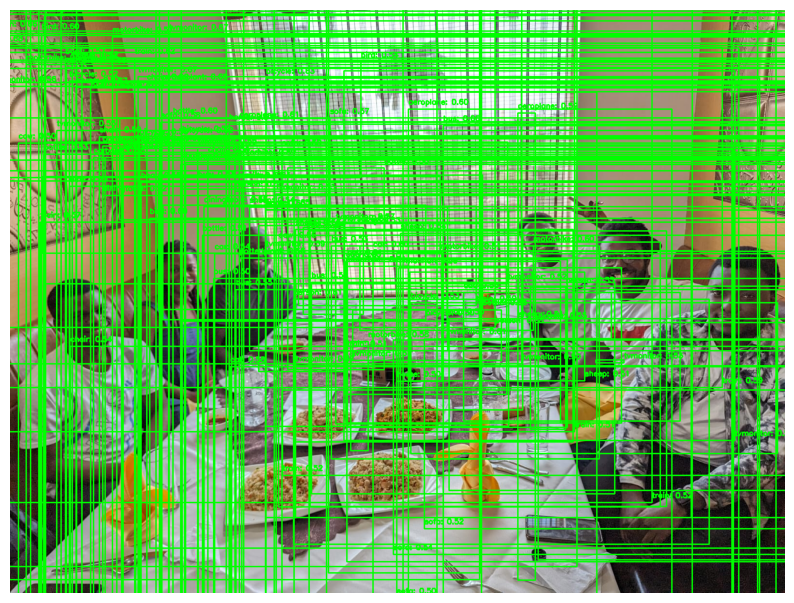

In [ ]:
image_path = '/content/drive/MyDrive/WhatsApp_Image_2023-11-02_at_1.38.42_PM.jpeg'  # Replace with your image path
input_data, original_image = preprocess_image(image_path)

# Perform inference
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name
result = session.run([output_name], {input_name: input_data})

# Postprocess the output
output = result[0]
boxes, box_scores = postprocess_output(output, original_image.shape)

# Draw bounding boxes on the original image
draw_boxes(original_image, boxes, box_scores)

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(original_image)
plt.axis('off')
plt.show()